<a href="https://colab.research.google.com/github/benny-liang0623/maboo/blob/main/cat_question_bert_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed May 11 12:00:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2

     |████████████████████████████████| 6.9 MB 4.4 MB/s 
     |████████████████████████████████| 776.8 MB 18 kB/s 
     |████████████████████████████████| 816 kB 41.6 MB/s 
     |████████████████████████████████| 596 kB 50.3 MB/s 
     |████████████████████████████████| 829 kB 46.9 MB/s 
     |████████████████████████████████| 136 kB 51.2 MB/s 
     |████████████████████████████████| 1.1 MB 39.3 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 271 kB 56.8 MB/s 
     |████████████████████████████████| 144 kB 49.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q transformers

     |████████████████████████████████| 4.0 MB 4.8 MB/s 
     |████████████████████████████████| 6.6 MB 36.1 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 880 kB 50.4 MB/s 


In [ ]:
# Import all libraries
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# FIX import problems with pl
# from torchtext.legacy.data import Batch
# https://github.com/PyTorchLightning/pytorch-lightning/issues/6210

In [ ]:
train_path = "/content/drive/MyDrive/CKIP/ckip_cat_train_pos.csv"

In [ ]:
train_data = pd.read_csv(train_path, encoding = "utf-8", converters={"name": lambda x: re.findall(r'[\u4e00-\u9fff]+',x)})
train_data = train_data[["name","product"]]
train_data.head()

,name,product
0,"[視舒坦單支裝人工淚液點眼液, 支入]",人工淚液
1,[優麗舒點眼液],人工淚液
2,[視舒坦單支裝人工],人工淚液
3,[乾眼淚液],人工淚液
4,"[參天柔潤人工淚液點眼液, 入]",人工淚液


In [ ]:
def to_string(name_list):
  s = ""
  for name in name_list:
    s += name
  return s

In [ ]:
def labeling(product):
  products = product.split(";")
  return products

In [ ]:
train = train_data

In [ ]:
train["name"] = train["name"].map(to_string)
train["product"] = train["product"].map(labeling)
train.head()

,name,product
0,視舒坦單支裝人工淚液點眼液支入,[人工淚液]
1,優麗舒點眼液,[人工淚液]
2,視舒坦單支裝人工,[人工淚液]
3,乾眼淚液,[人工淚液]
4,參天柔潤人工淚液點眼液入,[人工淚液]


In [ ]:
train.shape

(92306, 2)

In [ ]:
# Encode the tags(labels) in a binary format in order to be used for training

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

x = train["name"].tolist()

yt = mlb.fit_transform(train["product"])
yt.shape

(92306, 217)

In [ ]:
# Getting a sense of how the tags data looks like
print(yt[0])
print(mlb.inverse_transform(yt[0].reshape(1,-1)))
print(mlb.classes_)
print(len(mlb.classes_))

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[('人工淚液',)]
['BB霜' 'CC霜' 'DD霜' 'RTD調酒' '中式香腸' '乳酸菌' '人工淚液' '保久乳' '保溫杯' '保險套' '修容'
 '健腹器' '優格' '優酪乳' '兒童漱口水' '兒童牙刷' '兒童牙膏' '其他地墊(家用)' '冰箱' '冷氣/冷暖空調' '前導精華'
 '化妝水' '即溶咖啡' '即食雞胸' '即飲咖啡' '即飲奶茶' '即飲烏龍茶' '即飲無糖茶' '即飲紅茶' '即飲綠茶' '卸妝乳'
 '卸妝凝膠' '卸妝棉' '卸妝水' '卸妝油' '卸妝濕巾' '卸妝霜' '卸妝露' '卸甲液' '原味牛乳' '吸塵器' '吹風機'
 '咖啡機' '咖啡豆' '唇彩' '唇彩盤' '唇線筆' '唇膏' '唇蜜' '唇釉' '唇露' '啞鈴/槓鈴' '啤酒' '奶瓶'
 '妝前乳/隔離霜' '媽媽奶粉' '媽媽茶(哺乳茶)' '嬰幼乳液' '嬰幼手推車' '安全汽座' '巧拼地墊' '常溫醬包' '平板電腦'
 '廚房紙巾' '微波爐' '快煮壺' '快煮麵/乾拌麵' '成人奶粉' '成人牙刷' '成人牙膏' '成人紙尿褲' '成長幼兒奶粉' '指甲油'
 '按摩椅' '掃地機' '排油煙機' '擴香瓶' '收納櫃' '智慧型手機' '智慧錶' '杏仁

In [ ]:
questions = x

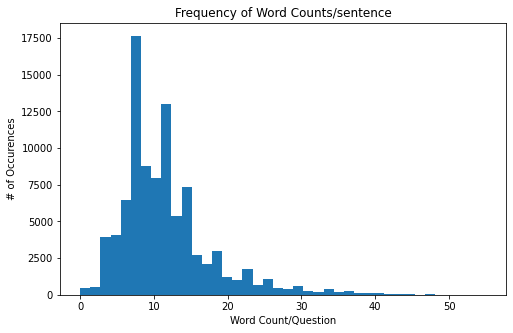

max word count: 55


In [ ]:
# compute no. of words in each question
word_cnt = [len(xi) for xi in x]
# Plot the distribution
plt.figure(figsize=[8,5])
plt.hist(word_cnt, bins = 40)
plt.xlabel('Word Count/Question')
plt.ylabel('# of Occurences')
plt.title("Frequency of Word Counts/sentence")
plt.show()
print("max word count:",max(word_cnt))

# Split the dataset into training ,validation and test set.



In [ ]:
from sklearn.model_selection import train_test_split
# First Split for Train and Test
x_train,x_test,y_train,y_test = train_test_split(x, yt, test_size=0.1, random_state=RANDOM_SEED,shuffle=True)
# Next split Train in to training and validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

In [ ]:
len(x_tr) ,len(x_val), len(x_test)

(66460, 16615, 9231)

Preparing the Dataset and DataModule  
First create QTagDataset class based on the Dataset class,that readies the text in a format needed for the BERT Model

In [ ]:
class QTagDataset (Dataset):
    def __init__(self,quest,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }

Since we are using Pytorch Lightning for Model training - we will setup the QTagDataModule class that is derived from the LightningDataModule

In [ ]:
class QTagDataModule (pl.LightningDataModule):
    
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=16,max_token_len=200):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self):
        self.train_dataset = QTagDataset(quest=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.val_dataset  = QTagDataset(quest=self.val_text,tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset  = QTagDataset(quest=self.test_text,tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset,batch_size = self.batch_size,shuffle = True , num_workers=2)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= 16)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= 16)

In [ ]:
# Initialize the Bert tokenizer
BERT_MODEL_NAME = "bert-base-chinese" # we will use the BERT base model(the smaller one)
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

In [ ]:
# Initialize the parameters that will be use for training
N_EPOCHS = 100
BATCH_SIZE = 64
MAX_LEN = 57
LR = 0.0012

In [ ]:
# Instantiate and set up the data_module
QTdata_module = QTagDataModule(x_tr,y_tr,x_val,y_val,x_test,y_test,Bert_tokenizer,BATCH_SIZE,MAX_LEN)
QTdata_module.setup()

In [ ]:
class QTagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, n_classes=217, steps_per_epoch=None, n_epochs=N_EPOCHS, lr=LR):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.linear_1 = nn.Linear(self.bert.config.hidden_size, 1024) # outputs = number of labels
        # self.linear_2 = nn.Linear(1024, 128)
        self.linear_3 = nn.Linear(1024, n_classes)
        '''我改了這邊'''
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids = input_ids ,attention_mask = attn_mask)
        output = torch.relu(self.linear_1(output.pooler_output))
        # output = torch.relu(self.linear_2(output))
        output = self.linear_3(output)
        '''和這邊'''
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch//3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]

## Predict on question data

In [ ]:
model = QTagClassifier.load_from_checkpoint("/content/drive/MyDrive/BERT/lightning_logs/version_3/checkpoints/QTag-epoch=12-val_loss=0.00.ckpt")
model = model.to(device) # moving model to cuda
model.eval()

Downloading:   0%|          | 0.00/393M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QTagClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
def predict_single_data(text, model = model, tokenizer = Bert_tokenizer, device = device, max_length=200) :
  text = tokenizer.encode_plus(
              text,
              None,
              add_special_tokens=True, # Add [CLS] [SEP]
              max_length= max_length,
              padding = 'max_length',
              return_token_type_ids= False,
              return_attention_mask= True, # Differentiates padded vs normal token
              truncation=True, # Truncate data beyond max length
              return_tensors = 'pt' # PyTorch Tensor format
            )
  input_ids = text['input_ids'].flatten()
  attention_mask = text['attention_mask'].flatten()
  input_ids = torch.unsqueeze(input_ids, 0).to(device)
  attention_mask = torch.unsqueeze(attention_mask, 0).to(device)
  pred_out = model(input_ids,attention_mask)
  pred_out = torch.sigmoid(pred_out)[0].detach().cpu().numpy()
  return pred_out

In [ ]:
def predict_multi_data(text_list, batchsize=16, model = model, tokenizer = Bert_tokenizer, device = device, max_length=200) :
  pred_out = []
  count=1
  while len(text_list)>0 :
    input_ids = []
    attention_mask = []
    for text in text_list[:batchsize] :
      text = tokenizer.encode_plus(
              text,
              None,
              add_special_tokens=True, # Add [CLS] [SEP]
              max_length= max_length,
              padding = 'max_length',
              return_token_type_ids= False,
              return_attention_mask= True, # Differentiates padded vs normal token
              truncation=True, # Truncate data beyond max length
              return_tensors = 'pt' # PyTorch Tensor format
            )
      input_ids.append(text['input_ids'].flatten().unsqueeze(0))
      attention_mask.append(text['attention_mask'].flatten().unsqueeze(0))
    input_ids = torch.cat(input_ids , axis =  0).to(device)
    attention_mask = torch.cat(attention_mask , axis =  0).to(device)
    _pred_out = model(input_ids,attention_mask)
    pred_out.append(torch.sigmoid(_pred_out).detach().cpu().numpy())
    text_list = text_list[batchsize:]
    count+=1
    print('\rProcess: %d / %f' %(count,97159/16), end='')
  return np.concatenate(pred_out , axis = 0)
  # return input_ids, attention_mask

In [ ]:
original_test_data = pd.read_csv("/content/drive/MyDrive/CKIP/original_data/brand_test(question).csv", encoding='utf-8')

In [ ]:
test_data = original_test_data[['name','brand']]
test_data['name'] = test_data['name'].map(lambda x: re.findall(r'[\u4e00-\u9fff]+',x))
test_data['name'] = test_data['name'].map(to_string)
test_data.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,name,brand
0,喜蜜輕透柔光粉底液入組,NaN
1,肌研卵肌溫和去角質化粧水入,NaN


In [ ]:
text_list = test_data['name']
test_data.shape

(97159, 2)

In [ ]:
import gc
gc.collect

<function gc.collect>

In [ ]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache>

In [ ]:
from torch.utils.data import DataLoader,Dataset
class QTagDataset (Dataset):
    def __init__(self, quest, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            
        }


In [ ]:
predit_dataloader = DataLoader(QTagDataset(text_list,Bert_tokenizer,200) ,batch_size=64)

In [ ]:
len(text_list)/64

1518.109375

In [ ]:
from tqdm.auto import tqdm
model.eval()
outputs = []
with torch.no_grad():
  for batch in tqdm(predit_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    _result = model(input_ids,attention_mask)
    _result = torch.sigmoid(_result)
    outputs.append(_result.cpu().numpy())

  0%|          | 0/1519 [00:00<?, ?it/s]

In [ ]:
outputs = np.concatenate(outputs)
outputs.shape

(97159, 217)

In [ ]:
pred_prob = []
count =1
for item in text_list:
  pred_prob.append(predict_single_data(item))
  count +=1
  print('\rProcess: %d / 97159' %count, end='')

Process: 97160 / 97159

## Classify

Optimal Threshold Value = 0.74

In [ ]:
# convert probabilities into 0 or 1 based on a threshold value
def classify(pred_prob,thresh):
    y_pred = []
    count = 1
    for tag_label_row in pred_prob:
        temp=[]
        max_index = 0
        max_confidence = 0
        for index, tag_label in enumerate(tag_label_row):
            if tag_label >= thresh:
                temp.append(1) # Infer tag value as 1 (present)
            else:
                temp.append(0) # Infer tag value as 0 (absent)
            if tag_label > max_confidence:
              max_index = index

        if sum(temp) == 0:
          temp[max_index] = 1
        y_pred.append(temp)

        count +=1
        print('\rProcess: %d / 97159' %count, end='')
        
    return y_pred

In [ ]:
y_act = np.array(classify(outputs,0.74))
y_act_label = mlb.inverse_transform(y_act)

In [ ]:
test_data['brand'] = y_act_label

In [ ]:
test_data['name'] = original_test_data['name']
test_data.sample(10)

In [ ]:
test_data.to_csv("/content/drive/MyDrive/BERT_copy/cat_question_bert_result_v2.csv",encoding="utf-8")